# DS 3000 - Assignment 11

**Student Name**: David Yu

**Date**: 3/28/25


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

## Question 1: 

(2 pts) Load the dataset "diabetes.csv", view the dimensions of the data, and gather summary statistics. Comment on your observations about the data.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
df = pd.read_csv('diabetes.csv')

print("Dataset Dimensions:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nSummary Statistics:")
print(df.describe())

Dataset Dimensions:
Number of rows: 768
Number of columns: 9

Summary Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160      

- The mean of the Outcome variable is 0.349, which means about 35% of patients have diabetes while 65% don't.
- All patients are at least 21 years old, with the oldest being 81.
- Pregnancies have a pretty wide range of 0 - 17.
- BMI has a mean of about 32, which is in the obese category.
- Glucose ranges from 0 to 199.

## Question 2:
(5 pts) Create two visualizations that demonstrate univariate and/or pairwise patterns in the data. Comment on the patterns.


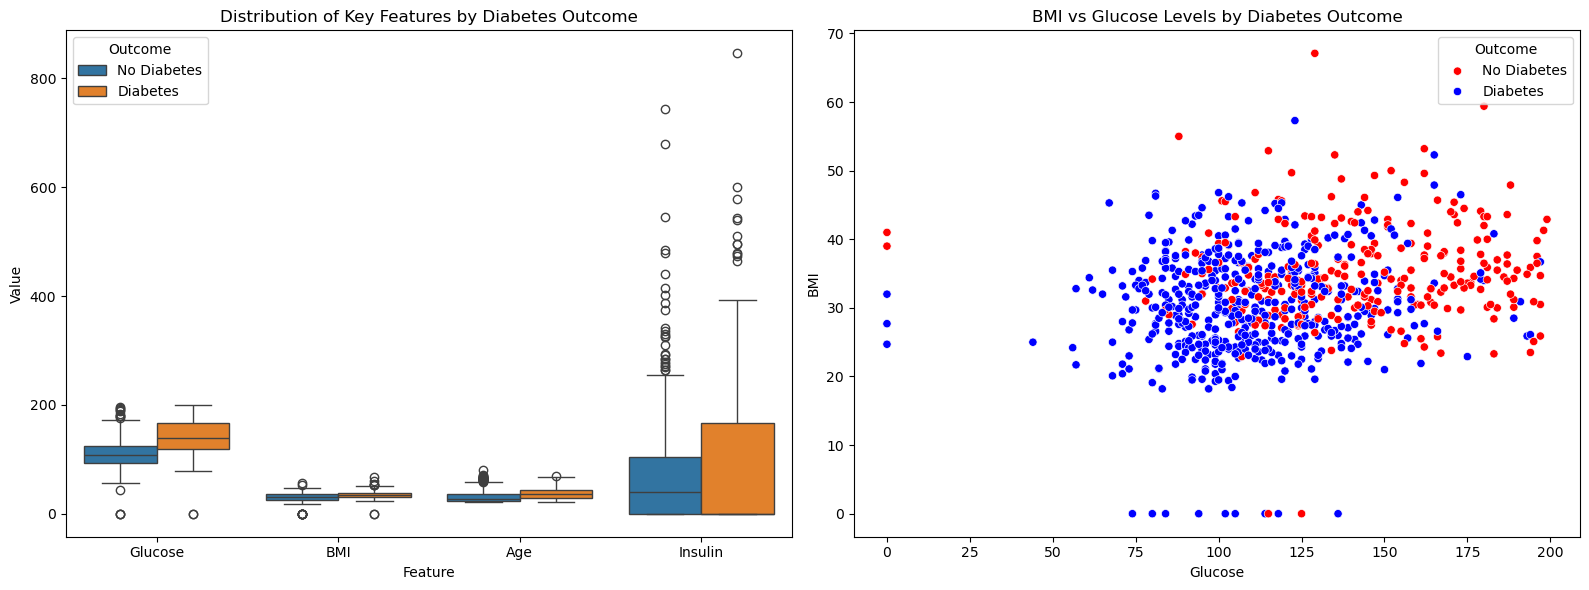

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Unvariate Patterns
selected_columns = ['Glucose', 'BMI', 'Age', 'Insulin']
df_melted = pd.melt(df, id_vars=['Outcome'], value_vars=selected_columns, 
                    var_name='Feature', value_name='Value')

sns.boxplot(x='Feature', y='Value', hue='Outcome', data=df_melted, ax=axes[0])
axes[0].set_title('Distribution of Key Features by Diabetes Outcome')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['No Diabetes', 'Diabetes'], title='Outcome')

# Pairwise Patterns
scatter = sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', 
                         data=df, palette=['blue', 'red'], ax=axes[1])
axes[1].set_title('BMI vs Glucose Levels by Diabetes Outcome')
axes[1].set_xlabel('Glucose')
axes[1].set_ylabel('BMI')
axes[1].legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

### Univariate Patterns
- Glucose levels are higher in patients with diabetes compared to patients without diabetes.
- BMI and age in patients with diabetes is slightly higher than patients without diabetes. However, the difference is very minor.
- Insulin shows a lot of variability, with numerous outliers in both patients with and without diabetes.

### Pairwise Patterns
- There is a lot of overlap in BMI values between both patients with and without diabetes.
- Points with high glucose and high BMI are likely to be patients with diabetes.
- No clear linear relationship between BMI and glucose.

## Question 3:
(3 pts) Evaluate the data for missing or invalid values. Then prepare the data, and ensure that you handle missing and invalid values (if they exist).

In [19]:
print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nZero values in each column:")
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count}")


Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero values in each column:
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11


In [21]:
df_cleaned = df.copy()

# Replace zeros with NaN
for col in zero_cols:
    df_cleaned[col] = df_cleaned[col].replace(0, np.nan)

# Replace NaN values with median values calculated for each outcome group
for outcome in [0, 1]:
    for col in zero_cols:
        median_value = df_cleaned.loc[(df_cleaned['Outcome'] == outcome) & 
                                     (df_cleaned[col].notnull()), col].median()
        df_cleaned.loc[(df_cleaned['Outcome'] == outcome) & 
                      (df_cleaned[col].isnull()), col] = median_value

print("\nMissing values after imputation:")
print(df_cleaned.isnull().sum())

print("\nSummary statistics after cleaning:")
print(df_cleaned.describe())


Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Summary statistics after cleaning:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.677083      72.389323      29.089844  141.753906   
std       3.369578   30.464161      12.106039       8.890820   89.100847   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  102.500000   
50%       3.000000  117.000000      72.000000      28.000000  102.500000   
75%       6.000000  140.250000      80.000000      32.000000  169.500000   
max      17.000000  199.000000     122.

## Question 4:
(5 pts) Partition the data into train/test sets. After which, perform the following:
- encode any categorical data
- normalize numeric data.

Tip: Ensure that you use sklearn to normalize and/or encode the training data, after which transform the test set (there is an example in the lecture).

In [24]:
X = df_cleaned.drop('Outcome', axis=1)
y = df_cleaned['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nSample of normalized training data:")
print(X_train_scaled_df.head())


Training set shape: (614, 8)
Testing set shape: (154, 8)

Sample of normalized training data:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.526397 -1.256387      -0.183902      -0.200844 -0.433914 -0.322099   
1     1.588046 -0.326563       0.808039      -0.553518  0.304833 -0.596116   
2    -0.828460  0.570053      -2.167784      -1.141307 -0.648922 -0.524006   
3    -1.130523  1.300629      -1.837137      -0.200844 -0.433914 -1.504701   
4     0.681856  0.404013       0.642715       0.974735  2.515560  1.999840   

   DiabetesPedigreeFunction       Age  
0                 -0.490735 -1.035940  
1                  2.415030  1.487101  
2                  0.549161 -0.948939  
3                 -0.639291  2.792122  
4                 -0.686829  1.139095  


## Question 5:
(10 pts) Build the model that predicts the target variable. Ensure that you:
- Instantiate the correct SVM model, train and evaluate it.
- Use GridSearchCV to tune at least two hyperparameters.**
- Perform cross validation.

**You'll need to read the documentation of the SVM algorithm to identify the hyperparameters.

- Display: 1) the best model/parameters and 2) the best score that was obtained.

In [33]:
svm = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8404638144742103


## Question 6:
(5 pts) Evaluate the scores from GridSearchCV for the training set and the test set to diagnose any bias-variance problems. Comment on the quality of the model.

In [35]:
best_model = grid_search.best_estimator_

# Training Set Accuracy
train_accuracy = best_model.score(X_train_scaled, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Test Set Accuracy
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Difference
difference = train_accuracy - test_accuracy
print(f"Difference (train - test): {difference:.4f}")

Training accuracy: 0.8795
Test accuracy: 0.8506
Difference (train - test): 0.0288


Both training and test accuracy is about 88% and 85%. This is pretty good predictive ability. In addition, the difference between training and test accuracy is only about 3%, which indicates good generalization.

## Question 7:
(15 pts) Perform the requirements from questions 5 & 6 above using 1) the k-nn algorithm and 2) any tree-based algorithm of your choice. Ensure that you explain your steps and discuss the quality of each model with respect to the bias-variance dilemma.

### k-nn

In [ ]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Cross-Validation Score: 0.8599760095961615


In [39]:
best_model = grid_search.best_estimator_

# Training accuracy
train_accuracy = best_model.score(X_train_scaled, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Testing accuracy
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Difference
difference = train_accuracy - test_accuracy
print(f"Difference (train - test): {difference:.4f}")

Training accuracy: 1.0000
Test accuracy: 0.8506
Difference (train - test): 0.1494


The model is able to get a 100% on training accuracy. However, the model is only able to get a 85% on test accuracy. Overall, the model's predictive accuracy is still pretty good. The difference between training and test accuracy is also about 15%, which is pretty high. This difference indicates that there is some overfitting prevelant in the model.

### Random Forest

In [43]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.8876582700253233


In [45]:
best_model = grid_search.best_estimator_

# Training accuracy
train_accuracy = best_model.score(X_train_scaled, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Difference
difference = train_accuracy - test_accuracy
print(f"Difference (train - test): {difference:.4f}")

Training accuracy: 1.0000
Test accuracy: 0.8896
Difference (train - test): 0.1104


The Random Forest model is also able to get a 100% accuracy on the training data. For the test accuracy, the model gets about an 89% accuracy. These accuracies are pretty high and show that the model is able to make good predictions. However, the difference of about 11% indicates that there is some overfitting in the model.

## Question 8: 
(15 pts) Perform steps 5-7 using the k-nn algorithm. Perform model tuning using at least 10 different values of k (ensure that you do not arbitrarily choose k). Show all your steps to create, evaluate and tune each version of the model. Indicate which model performed the best.

In [84]:
# Impute missing values with median for each column
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop('case', axis=1)), 
                         columns=df.drop('case', axis=1).columns)
df_imputed['case'] = df['case'].values

df_imputed['gestation_x_smoke'] = df_imputed['gestation'] * df_imputed['smoke']

X = df_imputed[['gestation', 'smoke', 'height', 'gestation_x_smoke']]
y = df_imputed['bwt']

print(f"\nAny NaN in X? {X.isna().any().any()}")
print(f"Any NaN in y? {y.isna().any()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_features = ['smoke']
encoder = OneHotEncoder(sparse_output=False, drop='first')

if categorical_features:
    encoder_fit = encoder.fit(X_train[categorical_features])
    encoded_train = encoder_fit.transform(X_train[categorical_features])
    
    encoded_feature_names = []
    for i, feature in enumerate(categorical_features):
        categories = encoder.categories_[i][1:]
        for category in categories:
            encoded_feature_names.append(f"{feature}_{category}")
    
    encoded_train_df = pd.DataFrame(
        encoded_train, 
        columns=encoded_feature_names,
        index=X_train.index
    )
    X_train_encoded = X_train.drop(categorical_features, axis=1).join(encoded_train_df)
    
    encoded_test = encoder_fit.transform(X_test[categorical_features])
    encoded_test_df = pd.DataFrame(
        encoded_test, 
        columns=encoded_feature_names,
        index=X_test.index
    )
    X_test_encoded = X_test.drop(categorical_features, axis=1).join(encoded_test_df)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


Any NaN in X? False
Any NaN in y? False


In [90]:
# Model Development
print("\nModel Development with k-NN")

# Model Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = round(math.sqrt(mse), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    
    return rmse, r2

# Test default k-NN model
default_knn = KNeighborsRegressor(n_neighbors=5)
default_rmse, default_r2 = evaluate_model(default_knn, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nModel Evaluation")
print(f"Default k-NN model (k=5):")
print(f"RMSE: {default_rmse}")
print(f"R^2: {default_r2}")


Model Development with k-NN

Model Evaluation
Default k-NN model (k=5):
RMSE: 18.01
R^2: 0.18


In [94]:
print("\nModel Tuning")

# Use square root of number of training samples as a reference point
n_samples = X_train.shape[0]
sqrt_n = int(math.sqrt(n_samples))
print(f"Number of training samples: {n_samples}")
print(f"Square root of n: {sqrt_n}")

k_values = [1, 3, 5, 7, 9, sqrt_n, sqrt_n+5, sqrt_n+10, sqrt_n*2, sqrt_n*3]
k_values = sorted(list(set([int(k) for k in k_values])))

print(f"Testing 10 k values: {k_values}")

results = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    rmse, r2 = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test)
    
    results.append({
        'k': k,
        'RMSE': rmse,
        'R^2': r2
    })
    
    print(f"k={k}, RMSE={rmse}, R^2={r2}")

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nBest model: k={int(best_model['k'])}")
print(f"RMSE: {best_model['RMSE']}")
print(f"R^2: {best_model['R^2']}")


Model Tuning
Number of training samples: 988
Square root of n: 31
Testing 10 k values: [1, 3, 5, 7, 9, 31, 36, 41, 62, 93]
k=1, RMSE=21.78, R^2=-0.2
k=3, RMSE=19.4, R^2=0.05
k=5, RMSE=18.01, R^2=0.18
k=7, RMSE=17.23, R^2=0.25
k=9, RMSE=17.17, R^2=0.25
k=31, RMSE=16.78, R^2=0.29
k=36, RMSE=16.89, R^2=0.28
k=41, RMSE=16.85, R^2=0.28
k=62, RMSE=16.89, R^2=0.28
k=93, RMSE=17.08, R^2=0.26

Best model: k=31
RMSE: 16.78
R^2: 0.29


The best model is the one that used k=31. It has a RMSE of 16.78 ounces and a R^2 of 0.29. 

## Question 9: 
(3 pts) Compare both the best model from both the Random Forest and k-NN algorithms and explain which model is the most suitable to predict birthweight. Justify your response.

The k-NN model has a RSME of 16.78 ounces, which is lower than the Random Forest model's RSME of 17.87 ounces. This means that the k-NN model's predictions are about 1.09 ounces closer to actual birth weights. The k-NN model has a R^2 value of 0.29, which is higher than the Random Forest model's R^2 value of 0.19. This means that the k-NN model explains about 10% more of the variance.

Overall, the k-NN model is more suitable to predict birthweight because it has a lower RSME and a higher R^2. This means the model has better predictive accuracy and explanatory power compared to the Random Forest model. Also, birth weight likely depends on complex local patterns in the feature space. k-NN's ability to make predictions based on similar cases (neighbors) rather than global rules seems to better capture these patterns.

## Question 10:
(+5 bonus points) The Random forest has a method that returns the importance of each feature in your model. Review the documentation to learn about feature importance. After which, write the appropriate code that demonstrates which features were the most important when making the predictions. Visualize the feature importance using the best model and explain the results.

Feature Importance:
             Feature  Importance
0          gestation    0.569102
1             height    0.288253
2  gestation_x_smoke    0.123185
3          smoke_1.0    0.019459


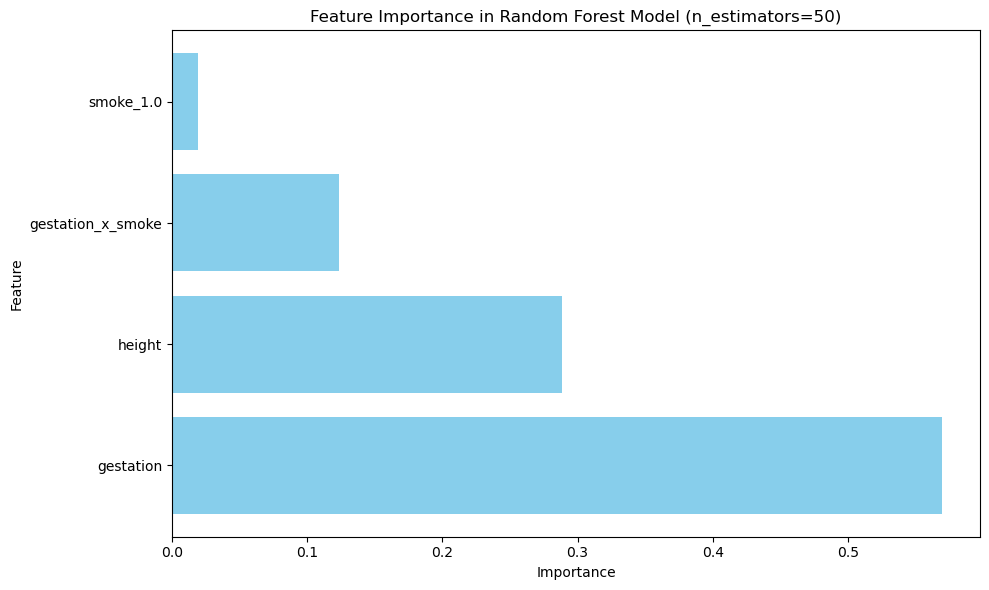

In [98]:
best_rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
best_rf_model.fit(X_train_encoded, y_train)

feature_importance = best_rf_model.feature_importances_
feature_names = X_train_encoded.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model (n_estimators=50)')
plt.tight_layout()
plt.show()

- Gestation is the most important feature as it accounts for more than 0.5 of the model's predictive power. This makes sense as longer pregnancies gives more time for babies to develop and gain weight.
- Height is the second most important feature, accounting for almost 0.3 of the model's predictive power. Taller mothers tend to produce heavier babies.
- The interaction between smoking and gestation only accounts for around 0.12 of the model's predictive power. This indicates that the effect of gestation period on birth weight differs between smokers and non-smokers.
- Smoking is the least important feature, only accounting for 0.02 of the model's predictive power. Its interaction with gestation is more significant, which suggests that smoking primarily matters in how it modifies the relationship between gestation and birth weight rather than as a standalone predictor.

## Helpful resources 
Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment inside the code cell, or you can list them below. 

You do not need to cite the official python documentation.
